<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/reservoir/fieldDevelopment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use of NeqSim for field development analysis
In this notebokk we will analyze a field development using neqsim. The analysis will be from reservoir to market.

We will use open data from Equinor to perform the field analsysis:

https://data.equinor.com/?_ga=2.147929335.153137805.1645782099-612346679.1645782099

In the follwoing case, we will use the open data for the decommissioned field Volve field:

https://data.equinor.com/dataset/Volve




# The Volve field
The Volve field was discovered in 1993 (Discovery well 15/9-19 SR). Located in the central part of the north sea, 5 km north of Sleipner East, waterdepth 80 m.

Volve is a field in the central part of the North Sea, five kilometres north of the Sleipner Øst field. The water depth is 80 metres. Volve was discovered in 1993, and the plan for development and operation (PDO) was approved in 2005. The field was developed with a jack-up processing and drilling facility. The vessel "Navion Saga" was used for storing stabilised oil. Production started in 2008.

https://www.norskpetroleum.no/en/facts/field/volve/

In [ ]:
%%capture
!pip install neqsim

In [ ]:
#Data https://www.norskpetroleum.no/en/facts/field/volve/
reservesOil = 10.2 #MSm3 oe
reservesGas = 0.8 #MSm3 oe

reservesNGL = 0.3 #MSm3 oe

reservoirT = 100.0
reservoirP = 200.0

# Creating reservoir fluid

   ComponentName  MolarComposition[-]  MolarMass[kg/mol]  RelativeDensity[-]
0       nitrogen                 0.53                NaN                 NaN
1            CO2                 3.30                NaN                 NaN
2        methane                72.98                NaN                 NaN
3         ethane                 7.68                NaN                 NaN
4        propane                 4.10                NaN                 NaN
5       i-butane                 0.70                NaN                 NaN
6       n-butane                 1.42                NaN                 NaN
7      i-pentane                 0.54                NaN                 NaN
8      n-pentane                 0.67                NaN                 NaN
9       n-hexane                 0.85                NaN                 NaN
10            C7                 1.33             0.0913               0.746
11            C8                 1.33             0.1041               0.768

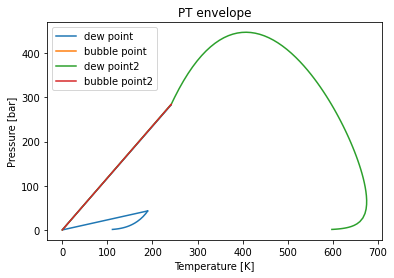

| 0                  | 1          | 2           | 3           | 4   | 5   | 6               |
|:-------------------|:-----------|:------------|:------------|:----|:----|:----------------|
|                    | total      | gas         | oil         |     |     |                 |
| nitrogen           | 5.18093E-3 | 5.53951E-3  | 7.17261E-6  |     |     | [mole fraction] |
| CO2                | 3.22586E-2 | 3.44605E-2  | 4.88567E-4  |     |     | [mole fraction] |
| methane            | 7.13404E-1 | 7.62596E-1  | 3.64317E-3  |     |     | [mole fraction] |
| ethane             | 7.50746E-2 | 8.01116E-2  | 2.39896E-3  |     |     | [mole fraction] |
| propane            | 4.00789E-2 | 4.25289E-2  | 4.72919E-3  |     |     | [mole fraction] |
| i-butane           | 6.84273E-3 | 7.18062E-3  | 1.96769E-3  |     |     | [mole fraction] |
| n-butane           | 1.3881E-2  | 1.44321E-2  | 5.92905E-3  |     |     | [mole fraction] |
| i-pentane          | 5.27868E-3 | 5.26015E-3  | 5.54607E-3

In [ ]:
import neqsim
from neqsim.thermo.thermoTools import *
from neqsim.process.processTools import simplereservoir,clearProcess,runProcess, getProcess
import pandas as pd

gascondensate = {'ComponentName':  ["nitrogen", "CO2", "methane", "ethane", "propane", "i-butane", "n-butane", "i-pentane", "n-pentane", "n-hexane", "C7", "C8", "C9", "C10", "C11", "C12", "C13", "C14", "C15", "C16", "C17", "C18", "C19", "C20"],
        'MolarComposition[-]':  [0.53, 3.3, 72.98, 7.68, 4.1, 0.7, 1.42, 0.54, 0.67, 0.85, 1.33, 1.33, 0.78, 0.61, 0.42, 0.33, 0.42, 0.24, 0.3, 0.17, 0.21, 0.15, 0.15, 0.8],
        'MolarMass[kg/mol]': [None,None, None,None,None,None,None,None,None,None,0.0913, 0.1041, 0.1188, 0.136, 0.150, 0.164, 0.179, 0.188, 0.204, 0.216, 0.236, 0.253, 0.27, 0.391],
        'RelativeDensity[-]': [None,None, None,None,None,None,None,None,None,None, 0.746, 0.768, 0.79, 0.787, 0.793, 0.804, 0.817, 0.83, 0.835, 0.843, 0.837, 0.84, 0.85, 0.877]
  }

gascondensatedf = pd.DataFrame(gascondensate)
print(gascondensatedf.head(30).to_string())
gascondensateFluid = fluid_df(gascondensatedf, lastIsPlusFraction=True)
gascondensateFluid.setMixingRule(2)
gascondensateFluid.setMultiPhaseCheck(True)
phaseenvelope(gascondensateFluid, True)

watersaturate(gascondensateFluid)
TPflash(gascondensateFluid)
printFrame(gascondensateFluid)

# Create reservoir and wells
Volve produced oil from sandstone of Middle Jurassic age in the Hugin Formation. The reservoir is at a depth of 2,700-3,100 metres. The western part of the structure is heavily faulted and communication across the faults is uncertain.

RECOVERY

The field was produced with water injection for pressure support.

In [ ]:
clearProcess()

gascondensateFluid.setPressure(reservoirP, 'bara')
gascondensateFluid.setTemperature(100.0, 'C')
reservoir1Ops = simplereservoir(gascondensateFluid, "Reservoir Formation 1", gasvolume=5.0 * 1e7, oilvolume=552.0 * 1e6, watervolume=10.0e6)

initFLowRate = 25020000.0
producedOilStream1 = reservoir1Ops.addOilProducer("SLP_A32562O")
producedOilStream1.setFlowRate(initFLowRate, "kg/day")

waterInjectionStream1 = reservoir1Ops.addWaterInjector("SLP_waterinj")
waterInjectionStream1.setFlowRate(initFLowRate/1.0, "kg/day")

fluid2 = gascondensateFluid.clone()
fluid2.addComponent('methane', 10.0);
fluid2.setPressure(reservoirP, 'bara')
fluid2.setTemperature(90.0, 'C')
reservoir2Ops = simplereservoir(fluid2, "Reservoir Formation 2", gasvolume=5.0 * 1e8, oilvolume=52.0 * 1e6, watervolume=10.0e6)

producedGasStream2 = reservoir2Ops.addGasProducer("SLP_A32562O")
producedGasStream2.setFlowRate(7.0, "MSm3/day")

runProcess()
getProcess().save('reservoir.neqsim')


# Calculate well flow rates
Insert Beggs and Brills multiphase calculation for well stream... and influx equiations for wells...

In [ ]:
from neqsim.process import getProcess, openprocess
resmodel = openprocess('reservoir.neqsim')
reservoir1 = resmodel.getUnit('Reservoir Formation 1')
wellStream1 = reservoir1.getOilProducer(0).getStream()
wellStream1.setFlowRate(initFLowRate, "kg/day")

reservoir2 = resmodel.getUnit('Reservoir Formation 2')
wellStream2 = reservoir2.getGasProducer(0).getStream()

deltat = 24*60*60.0*365
resmodel.setTimeStep(deltat)

resmodel.runTransient()

print('pressure res 1 ', reservoir1.getReservoirFluid().getPressure('bara'))
print('pressure res 2 ', reservoir2.getReservoirFluid().getPressure('bara'))

pressure res 1  197.46877378795674
pressure res 2  194.14692307797813


# Add subsea system

In [ ]:
from neqsim.process.processTools import mixer,cooler

template1 = mixer("template 1")
template1.addStream(wellStream1)
template1.addStream(wellStream2)

template1.run()

pipe = jNeqSim.processSimulation.processEquipment.pipeline.PipeBeggsAndBrills(template1.getOutStream())
pipe.setDiameter(1.017112);
pipe.setPipeWallRoughness(5e-6);
pipe.setLength(1000);
pipe.setElevation(500.0);
pipe.setAngle(0);
pipe.setNumberOfIncrements(2);
pipe.run()

print('pressure drop ', pipe.getPressureDrop(), 'bara')
print('flow regine ',pipe.getFlowRegime())

pipeline = cooler(pipe.getOutStream())
pipeline.setOutPressure(85.0, 'bara')
pipeline.setOutTemperature(45.0, 'C')
pipeline.run()

printFrame(pipe.getOutStream().getFluid())
printFrame(pipeline.getOutStream().getFluid())

#print('gas flow rate ',



pressure drop  55.321459591667 bara
flow regine  TRANSITION
| 0                  | 1           | 2                 | 3                 | 4   | 5   | 6               |
|:-------------------|:------------|:------------------|:------------------|:----|:----|:----------------|
|                    | total       | gas               | oil               |     |     |                 |
| nitrogen           | 3.98901E-3  | 5.58469E-3        | 6.78574E-4        |     |     | [mole fraction] |
| CO2                | 2.97125E-2  | 3.59927E-2        | 1.66837E-2        |     |     | [mole fraction] |
| methane            | 6.00755E-1  | 7.90369E-1        | 2.07379E-1        |     |     | [mole fraction] |
| ethane             | 7.46447E-2  | 8.21468E-2        | 5.90808E-2        |     |     | [mole fraction] |
| propane            | 4.58046E-2  | 3.98882E-2        | 5.80787E-2        |     |     | [mole fraction] |
| i-butane           | 8.63655E-3  | 5.98422E-3        | 1.41391E-2        |     |  

# Setting up topside process


In [ ]:
from neqsim.process.processTools import separator3phase

inletSeparator = separator3phase(pipeline.getOutStream())
inletSeparator.setName("1st stage separator")

inletSeparator.run()


print('gas flow ', inletSeparator.getGasOutStream().getFlowRate('MSm3/day'), ' MSm3/day')
print('oil flow ', inletSeparator.getOilOutStream().getFlowRate('kg/day')/inletSeparator.getOilOutStream().getFluid().getPhase('oil').getDensity('kg/m3'), ' m3/day')

gas flow  6.29206218495144  MSm3/day
oil flow  37283.37258974767  m3/day
